<div >
<img src = "../banner.jpg" />
</div>

# Spatial Data

In [1]:
require("pacman")
p_load("tidyverse","sf","modeldata","geojsonio")

Loading required package: pacman



In [2]:
data("ames", package = "modeldata")

In [3]:
dim(ames)

[1] 2930   74

In [4]:
class(ames)

[1] "tbl_df"     "tbl"        "data.frame"

![](figs/mercator.gif)

In [5]:
ames_sf <- sf::st_as_sf(
  ames,
  # "coords" is in x/y order -- so longitude goes first!
  coords = c("Longitude", "Latitude"),
  # Set our coordinate reference system to EPSG:4326,
  # the standard WGS84 geodetic coordinate reference system
  crs = 4326
)

In [6]:
class(ames_sf)

[1] "sf"         "tbl_df"     "tbl"        "data.frame"

In [7]:
head(ames_sf)

MS_SubClass                         MS_Zoning                Lot_Frontage
1 One_Story_1946_and_Newer_All_Styles Residential_Low_Density  141         
2 One_Story_1946_and_Newer_All_Styles Residential_High_Density  80         
3 One_Story_1946_and_Newer_All_Styles Residential_Low_Density   81         
4 One_Story_1946_and_Newer_All_Styles Residential_Low_Density   93         
5 Two_Story_1946_and_Newer            Residential_Low_Density   74         
6 Two_Story_1946_and_Newer            Residential_Low_Density   78         
  Lot_Area Street Alley           Lot_Shape          Land_Contour Utilities
1 31770    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
2 11622    Pave   No_Alley_Access Regular            Lvl          AllPub   
3 14267    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
4 11160    Pave   No_Alley_Access Regular            Lvl          AllPub   
5 13830    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
6  9978    Pave   No_Alley_Access Slightly_Irregular Lvl          AllPub   
  Lot_Config ⋯ Pool_QC Fence           Misc_Feature Misc_Val Mo_Sold Year_Sold
1 Corner     ⋯ No_Pool No_Fence        None             0    5       2010     
2 Inside     ⋯ No_Pool Minimum_Privacy None             0    6       2010     
3 Corner     ⋯ No_Pool No_Fence        Gar2         12500    6       2010     
4 Corner     ⋯ No_Pool No_Fence        None             0    4       2010     
5 Inside     ⋯ No_Pool Minimum_Privacy None             0    3       2010     
6 Inside     ⋯ No_Pool No_Fence        None             0    6       2010     
  Sale_Type Sale_Condition Sale_Price geometry                  
1 WD        Normal         215000     POINT (-93.61975 42.05403)
2 WD        Normal         105000     POINT (-93.61976 42.05301)
3 WD        Normal         172000     POINT (-93.61939 42.05266)
4 WD        Normal         244000     POINT (-93.61732 42.05125)
5 WD        Normal         189900     POINT (-93.63893 42.0609) 
6 WD        Normal         195500     POINT (-93.63893 42.06078)

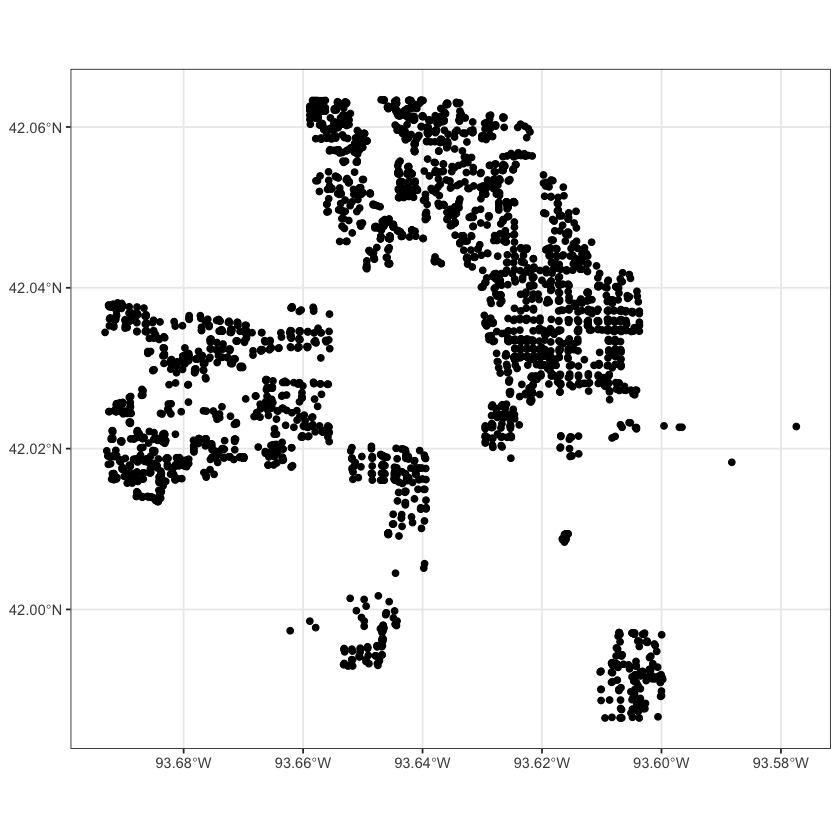

In [8]:
ggplot() +
    geom_sf(data=ames_sf)+
    theme_bw()

In [9]:
p_load("leaflet")

In [10]:
map1<-leaflet()  %>% 
        addTiles()  %>% 
        addCircleMarkers(data=ames_sf)

In [11]:
#workaround to show in Jupyter Notebook (not needed in Rstudio)
p_load("htmlwidgets","IRdisplay")

saveWidget(map1, 'demo1.html', selfcontained = FALSE)
display_html('<iframe src="demo1.html" width="800" height="800"></iframe>')

In [12]:
#Different Tiles
map2<-leaflet()  %>% 
    addProviderTiles(providers$Stamen.Toner)  %>% 
    addCircles(data=ames_sf)

In [13]:
#workaround to show in Jupyter Notebook (not needed in Rstudio)
p_load("htmlwidgets","IRdisplay")

saveWidget(map2, 'demo2.html', selfcontained = FALSE)
display_html('<iframe src="demo2.html" width="800" height="800"></iframe>')

# Clustering
## Etapas

Las etapas del análisis de clusters podemos resumirlas de la siguiente forma:

1. Iniciamos con una matriz de datos

    \begin{align}
X_{n\times k}=\left(\begin{array}{cccc}
x_{11} &  & \dots & x_{1k}\\
\\
\vdots &  & x_{ik} & \vdots\\
\\
x_{n1} &  & \dots & x_{nk} 
\end{array}\right)
    \end{align}

2. Calculamos la matriz de distancia o disimilitud

\begin{align}
D_{n\times n}=\left(\begin{array}{ccccc}
d_{11} &  & \dots &  & d_{1n}\\
 & \ddots\\
\vdots &  & d_{jj} &  & \vdots\\
 &  &  & \ddots\\
d_{n1} &  & \dots &  & d_{nn}
\end{array}\right)
\end{align}


3. Aplicamos el algoritmo de clustering. Existen varios tipos, en esta semana nos centramos en aquellos  **Algoritmos basados en centroides**. En estos algoritmos cluster está representado por un centroide. Los clusters se construyen en función de la distancia al centroide del grupo.

In [14]:
set.seed(101011)
ames_sample<-ames_sf  %>% sample_frac(size=1/3) 
db<- ames_sample  %>%  select(geometry)
head(db)

geometry
<POINT [°]>
POINT (-93.61843 42.03981)
POINT (-93.60064 41.99282)
POINT (-93.65627 42.0633)
POINT (-93.64717 42.04741)
POINT (-93.68144 42.01627)
POINT (-93.68496 42.02199)


In [15]:
db<-st_distance(db)
head(db)

Units: [m]
         [,1]     [,2]     [,3]     [,4]      [,5]      [,6]     [,7]     [,8]
[1,]    0.000 5427.658 4073.055 2518.941 5825.6619 5841.5591 1510.612 1611.668
[2,] 5427.658    0.000 9085.296 7184.221 7167.6837 7685.3927 6906.400 7033.275
[3,] 4073.055 9085.296    0.000 1921.100 5627.5895 5168.5484 2717.986 2770.083
[4,] 2518.941 7184.221 1921.100    0.000 4471.9924 4210.6710 1707.292 1902.218
[5,] 5825.662 7167.684 5627.589 4471.992    0.0000  699.5592 5957.744 6186.400
[6,] 5841.559 7685.393 5168.548 4210.671  699.5592    0.0000 5794.237 6017.105
         [,9]    [,10]     [,11]     [,12]     [,13]     [,14]     [,15]
[1,] 2374.887 1291.040  923.7357  888.2099 6466.3955 3350.2410 5587.1752
[2,] 7622.742 6697.511 5831.2306 4860.4381 8067.0908 8596.5586  160.8872
[3,] 1746.879 3307.870 3347.6877 4944.6924 5711.1813  983.0459 9244.9819
[4,] 1186.347 2321.911 1636.3247 3400.6278 4831.6279 1746.3548 7343.1574
[5,] 5658.198 6431.639 5071.4725 6384.1873  899.4295 6028.0594 7281.667

In [16]:
db<-units::drop_units(db)

In [17]:
k3 <- kmeans(db, centers = 3, nstart = 25)
str(k3)

List of 9
 $ cluster     : int [1:977] 3 1 3 3 2 2 3 3 3 3 ...
 $ centers     : num [1:3, 1:977] 5238 5005 1902 1646 7029 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3] "1" "2" "3"
  .. ..$ : NULL
 $ totss       : num 3.22e+12
 $ withinss    : num [1:3] 8.27e+10 2.93e+11 7.39e+11
 $ tot.withinss: num 1.11e+12
 $ betweenss   : num 2.1e+12
 $ size        : int [1:3] 78 307 592
 $ iter        : int 2
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [18]:
ames_sample<- ames_sample %>% mutate(clusters=factor(k3$cluster))

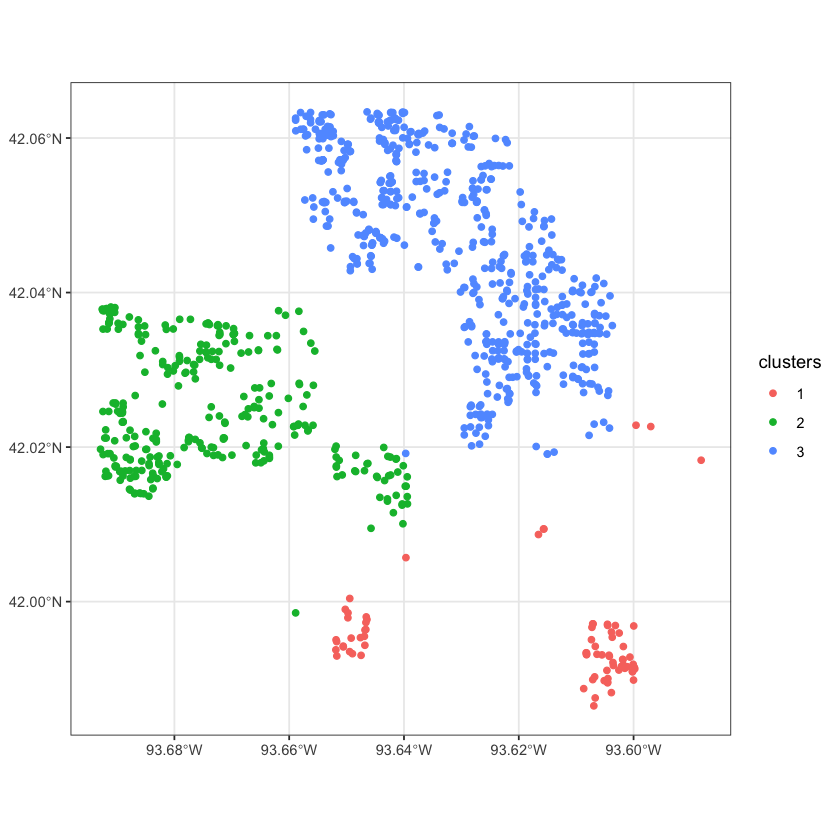

In [19]:
ggplot() +
  geom_sf(data=ames_sample,aes(col=clusters)) + #graficamos las predicciones
  theme_bw()

## ¿Cuántos K (clusters) debemos elegir?

### Método del codo

In [ ]:
# función que calcula la SSR within-cluster 
wss <- function(k) {
  kmeans(db, k, nstart = 25 )$tot.withinss
}

# Calculamos y graficamos para k = 1 hasta k = 12
wss_values <- sapply(1:12,wss)

plot(1:12, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Número de clusters (K)",
       ylab="SSR within-clusters total")

### Coeficiente de Silhouette

In [ ]:
p_load("cluster")
# función para extraer el coeficiente de silhouette

avg_sil <- function(k) {
  km.res <- kmeans(db, centers = k, nstart = 25)
  ss <- cluster::silhouette(km.res$cluster, dist(db))
  mean(ss[, 3])
}


# Calcular el coeficiente de silhouette para  k = 2 hasta k = 12
valores_sil <-  sapply(2:12,avg_sil)

plot(2:12, valores_sil,
       type = "b", pch = 19, frame = FALSE, 
       xlab="Número de clusters (K)",
       ylab = "Coeficiente de Silhouette")

In [ ]:
k4 <- kmeans(db, centers = 4, nstart = 25)

ames_sample<- ames_sample %>% mutate(clusters=factor(k4$cluster))

In [ ]:
ggplot() +
  geom_sf(data=ames_sample,aes(col=clusters)) + #graficamos las predicciones
  theme_bw()

# Super learner

Vamos a modelar los precios de venta de las casas en el conjunto de datos de Ames. Digamos que el precio de venta de estas casas depende del año en que se construyeron, su superficie habitable (tamaño) y el tipo de casa que son (dúplex vs. townhouse vs. unifamiliar)

In [ ]:
ames<- ames  %>% mutate(logprice=log(Sale_Price))


In [ ]:
p_load("caret")
set.seed(1011)
inTrain <- createDataPartition(
  y = ames$logprice,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- ames[ inTrain,]
test  <- ames[-inTrain,]
colnames(train)

In [ ]:
p_load("SuperLearner")


In [ ]:
# Review available models.
listWrappers()

In [ ]:
y<-train$logprice
X<- train  %>% select(Year_Built, Bldg_Type, Gr_Liv_Area)

In [ ]:
sl.lib <- c("SL.randomForest", "SL.lm")

# Fit using the SuperLearner package,

fitY <- SuperLearner(Y = y, X = data.frame(X),
    method = "method.NNLS", SL.library = sl.lib)

fitY

In [ ]:
yhat_Sup <- predict(fitY, newdata = data.frame(test), onlySL = T)$pred
head(yhat_Sup)

In [ ]:
# Customize the defaults for random forest.
custon_ranger = create.Learner("SL.ranger", params = list(num.trees = 1000))

# Look at the object.
custon_ranger$names


In [ ]:
custom_rf = create.Learner("SL.randomForest",
                     tune = list(mtry = round(c(1, sqrt(3), 3))))
custom_rf$names

In [ ]:
# Customize the defaults for random forest.
custon_glmnet = create.Learner("SL.glmnet", tune = list(alpha = seq(0, 1, length.out=5)))

# Look at the object.
custon_glmnet$names

In [ ]:

sl.lib <- c("SL.randomForest", "SL.lm",custon_ranger$names,custon_glmnet$names,custom_rf$names)

# Fit using the SuperLearner package,

fitY <- SuperLearner(Y = y, X = data.frame(X),
    method = "method.NNLS", SL.library = sl.lib)

fitY